In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

        for series_num in series:
        # Plot the time series data
            plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()


def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series


def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    
    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according 
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern


def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern


def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

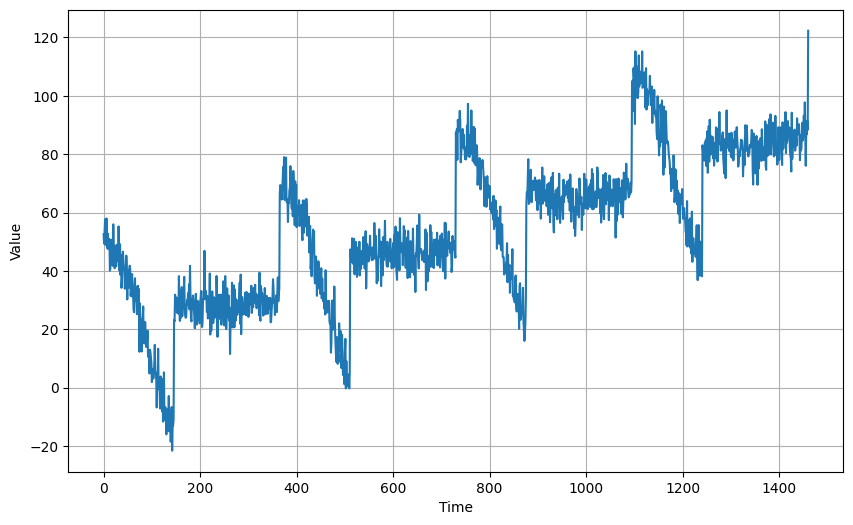

In [4]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

## Splitting data

In [5]:
split_time = 1000
train_time = time[:split_time]
x_train = series[:split_time]

valid_time = time[split_time:]
x_valid = series[split_time:]

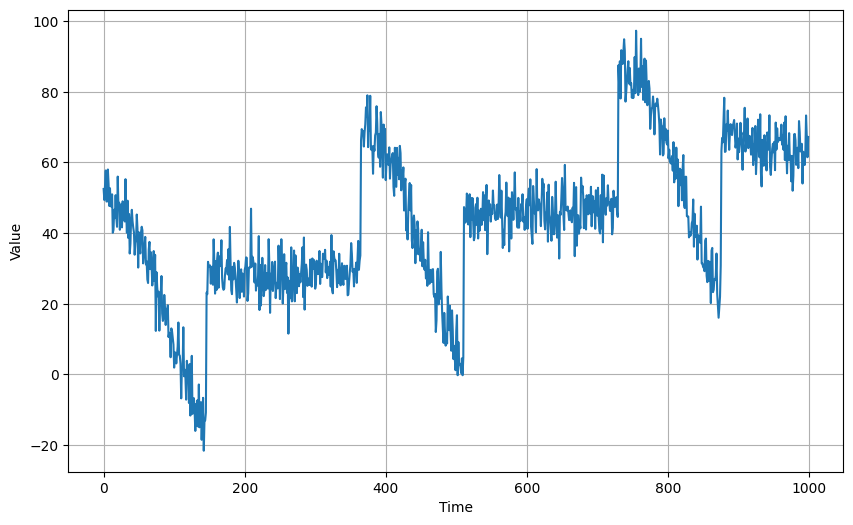

In [6]:
# Plot the train set
plot_series(train_time, x_train)

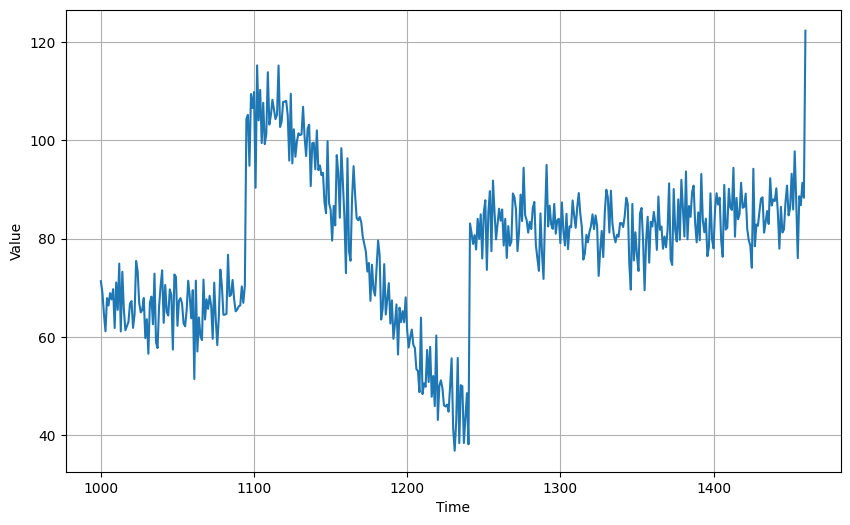

In [7]:
# Plot the train set
plot_series(valid_time, x_valid)

In [8]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [10]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [11]:
# Print properties of a single batch
for windows in dataset.take(1):
    print(f'data type: {type(windows)}')
    print(f'number of elements in the tuple: {len(windows)}')
    print(f'shape of first element: {windows[0].shape}')
    print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 20)
shape of second element: (32,)


In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=[window_size]),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,457
Trainable params: 3,457
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Set the training parameters
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

In [14]:
with tf.device('GPU:0'):
    model.fit(dataset, epochs=500, verbose=0)
    print("Training is done!")

Training is done!


## Prediction

In [15]:
forecast = []
for time in range(len(series) - window_size):
    print(f'\r{time}/{len(series) - window_size}', end='')
    forecast.append(model.predict(series[time:time + window_size][np.newaxis], verbose=0))
    
forecast = forecast[split_time - window_size:]

print("")
print(f'length of forecast is {len(forecast)}')
print(f'length of x_valid is {len(x_valid)}')

1440/1441
length of forecast is 461
length of x_valid is 461


In [16]:
results = np.array(forecast).squeeze()

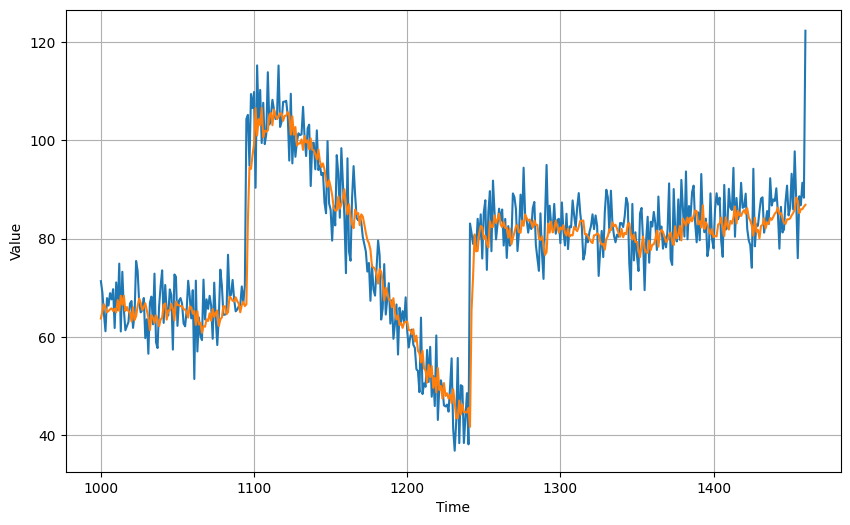

In [17]:
plot_series(valid_time, (x_valid, results))

In [18]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

41.781334
4.712324


## Pure forecasting

In [19]:
pure_forecast = []
pure_forecast.extend(x_train[-365:])
pure_forecast = np.array(pure_forecast, dtype='float32')
temp_pure = pure_forecast.copy()

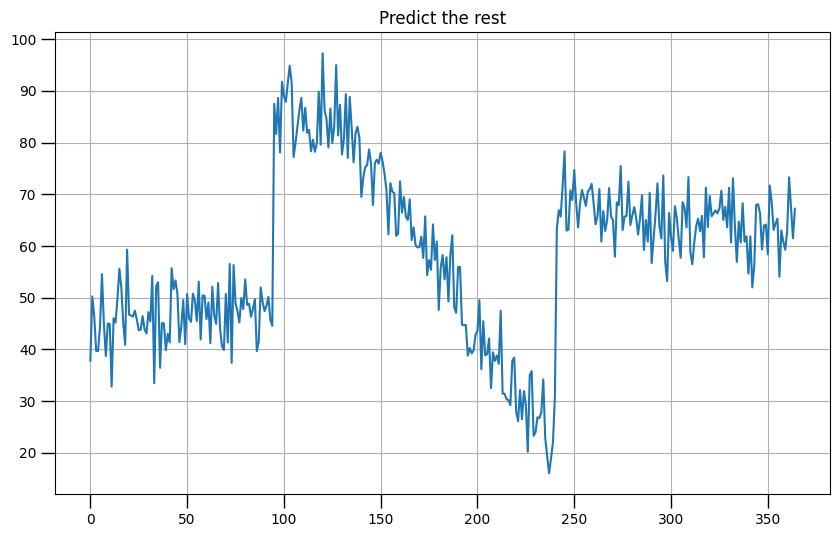

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(range(pure_forecast.shape[0]), pure_forecast);
plt.title('Predict the rest');
plt.grid(True)
plt.tick_params('both', length=10, width=1)

In [21]:
for i in range(365):
    print(f'\r%{i * 100 / 364:.2f}', end='')
    new_prediction = model.predict(pure_forecast[i:i + window_size][np.newaxis], verbose=0)
    pure_forecast = np.hstack([pure_forecast, new_prediction.squeeze()])

%100.00

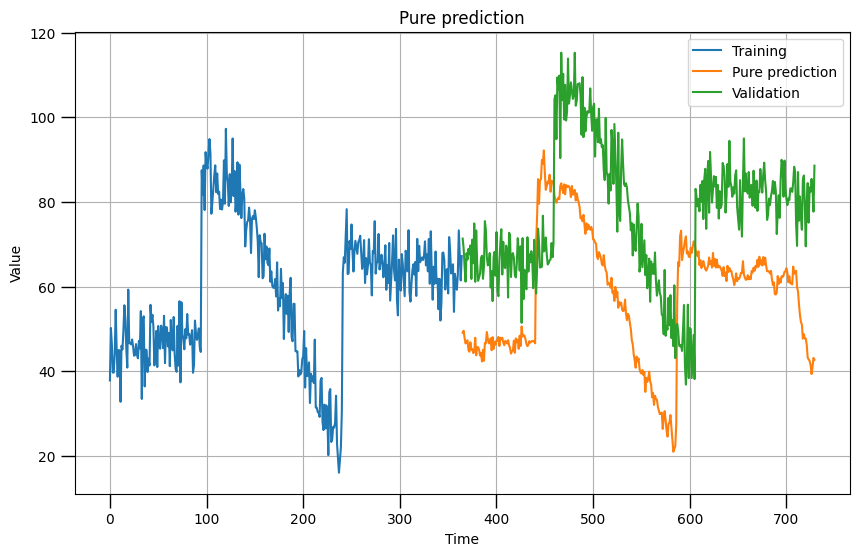

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(range(temp_pure.shape[0]), temp_pure, label='Training');
plt.plot(range(temp_pure.shape[0], pure_forecast.shape[0]), pure_forecast[temp_pure.shape[0]:], label='Pure prediction');
plt.plot(range(temp_pure.shape[0], temp_pure.shape[0] + 365), x_valid[:365], label='Validation')
plt.title('Pure prediction');
plt.xlabel('Time')
plt.ylabel('Value');
plt.grid()
plt.tick_params('both', length=10, width=1, which='both')
plt.legend();

In [23]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid[:365], pure_forecast[temp_pure.shape[0]:]).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid[:365], pure_forecast[temp_pure.shape[0]:]).numpy())

558.66345
22.537128


## Using learning rate callback

In [24]:
lr = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch / 20))

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=[window_size]),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                1344      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,457
Trainable params: 3,457
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Set the training parameters
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

In [27]:
with tf.device('GPU:0'):
    history = model.fit(dataset, epochs=100, verbose=0, callbacks=[lr])
    print("Training is done!")

Training is done!


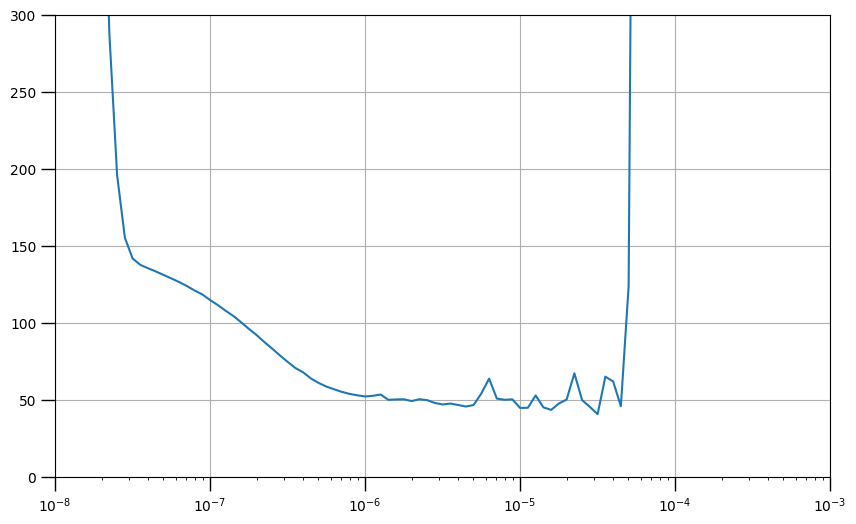

In [28]:
lrs = 1e-8 * 10 ** (np.arange(100) / 20)
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.semilogx(lrs, history.history['loss'])
plt.tick_params('both', length=10, width=1)
plt.axis([1e-8, 1e-3, 0, 300]);

In [29]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=[window_size]),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                1344      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,457
Trainable params: 3,457
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Set the training parameters
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=2e-6, momentum=0.9))

In [31]:
with tf.device('GPU:0'):
    history = model.fit(dataset, epochs=500, verbose=0)
    print("Training is done!")

Training is done!


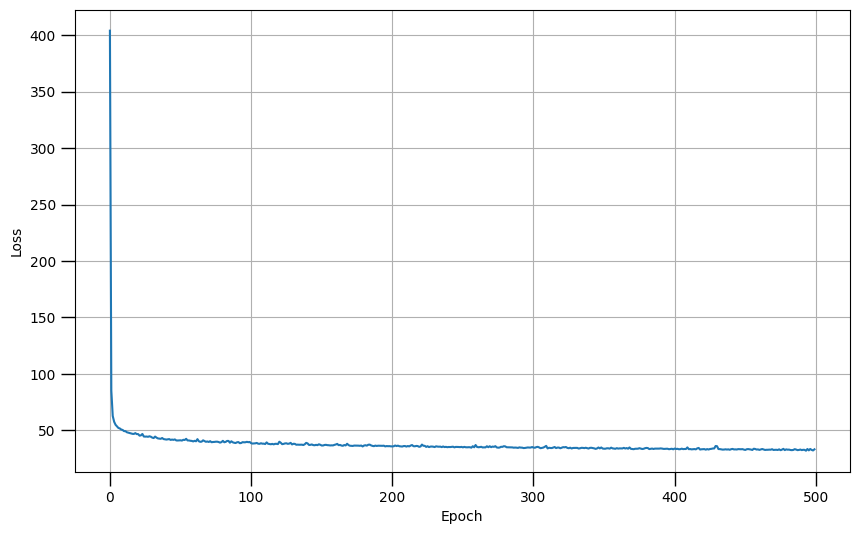

In [32]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.tick_params('both', length=10, width=1)
plt.plot(history.epoch, history.history['loss']);
plt.xlabel('Epoch')
plt.ylabel('Loss');

In [33]:
forecast = []
for time in range(len(series) - window_size):
    print(f'\r{time}/{len(series) - window_size}', end='')
    forecast.append(model.predict(series[time:time + window_size][np.newaxis], verbose=0))
    
forecast = forecast[split_time - window_size:]

print("")
print(f'length of forecast is {len(forecast)}')
print(f'length of x_valid is {len(x_valid)}')

1440/1441
length of forecast is 461
length of x_valid is 461


In [34]:
results = np.array(forecast).squeeze()

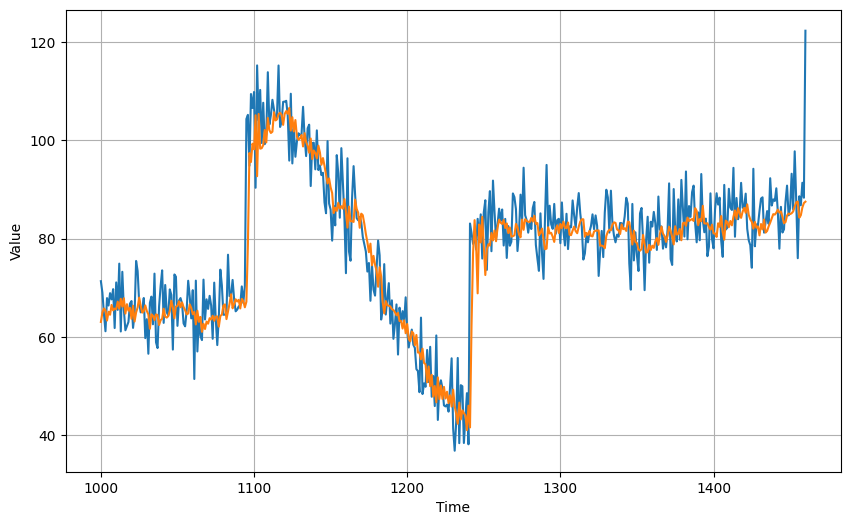

In [35]:
plot_series(valid_time, (x_valid, results))

In [36]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

44.285236
4.815473


## Pure Forecasting

In [37]:
pure_forecast = []
pure_forecast.extend(x_train[-365:])
pure_forecast = np.array(pure_forecast, dtype='float32')
temp_pure = pure_forecast.copy()

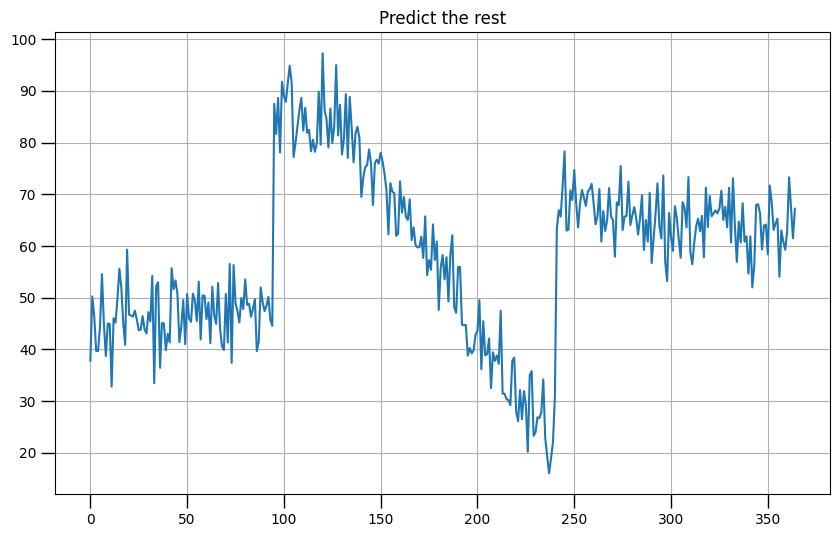

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(range(pure_forecast.shape[0]), pure_forecast);
plt.title('Predict the rest');
plt.grid(True)
plt.tick_params('both', length=10, width=1)

In [39]:
for i in range(365):
    print(f'\r%{i * 100 / 364:.2f}', end='')
    new_prediction = model.predict(pure_forecast[i:i + window_size][np.newaxis], verbose=0)
    pure_forecast = np.hstack([pure_forecast, new_prediction.squeeze()])

%100.00

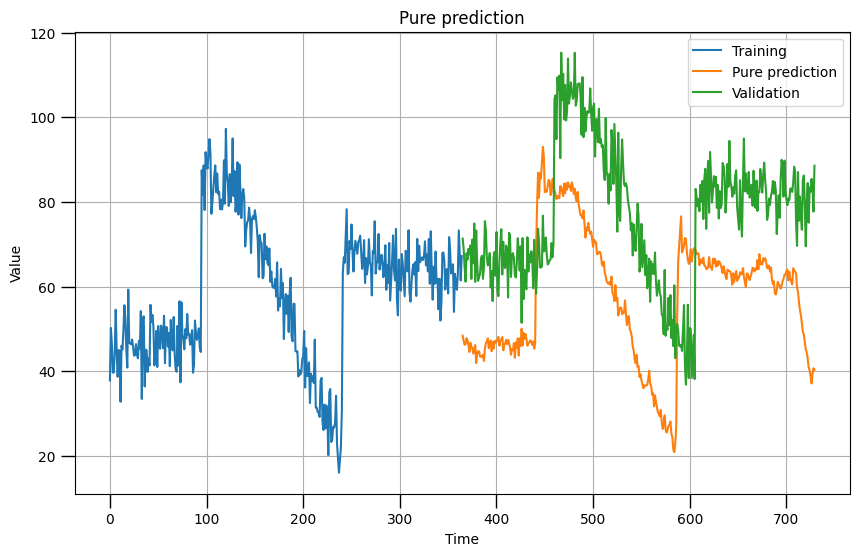

In [40]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(range(temp_pure.shape[0]), temp_pure, label='Training');
plt.plot(range(temp_pure.shape[0], pure_forecast.shape[0]), pure_forecast[temp_pure.shape[0]:], label='Pure prediction');
plt.plot(range(temp_pure.shape[0], temp_pure.shape[0] + 365), x_valid[:365], label='Validation')
plt.title('Pure prediction');
plt.xlabel('Time')
plt.ylabel('Value');
plt.tick_params('both', length=10, width=1, which='both')
plt.legend();

In [41]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid[:365], pure_forecast[temp_pure.shape[0]:]).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid[:365], pure_forecast[temp_pure.shape[0]:]).numpy())

572.1588
22.75485
